## Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import warnings
from pyzipcode import ZipCodeDatabase

/Users/christinemerkel/neuefische/first_eda/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Reading in the data

In [4]:
df_king_county = pd.read_csv('../data/King_County_House_prices_dataset.csv')

## Inspecting the data

In [5]:
df_king_county.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [6]:
df_king_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
df_king_county.shape

(21597, 21)

In [8]:
df_king_county.date.min()
df_king_county.date.max()

'9/9/2014'

The data contains 21597 houses sold from 2014-05-02 till 2015-05-27. <br>
The features are: <br>
* id - unique identified for a house
* date - house was sold
* price - is prediction target
* bedrooms - # of bedrooms
* bathrooms - # of bathrooms
* sqft_living - footage of the home
* sqft_lot - footage of the lot
* floors - floors (levels) in house
* waterfront - House which has a view to a waterfront
* view - Has been viewed
* condition - How good the condition is ( Overall )
* grade - overall grade given to the housing unit, based on King County grading system
* sqft_above - square footage of house apart from basement
* sqft_basement - square footage of the basement
* yr_built - Built Year
* yr_renovated - Year when house was renovated
* zipcode - zip
* lat - Latitude coordinate
* long - Longitude coordinate
* sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
* sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


## Cleaning the data

In [9]:
#In column date change type object to type datetime
df_king_county['date'] = pd.to_datetime(df_king_county['date'])

#in column sqft_basement change dtype object to float. Apparently this column contains also 454 '?'s, so these have to be replaced.
df_king_county.sqft_basement.value_counts()
df_king_county.sqft_basement = df_king_county.sqft_basement.replace('?', '0')
df_king_county.sqft_basement =  df_king_county.sqft_basement.astype(float)

#check for nans in the entire DataFrame
for col in df_king_county.columns: 
    if  df_king_county[col].isnull().values.any(): print(col)

#waterfront, view and yr_renovated have nans
#waterfront has values 0 and 1, so replace Nans by 0
df_king_county['waterfront'].isnull().sum()   
df_king_county['waterfront'].value_counts()
df_king_county.waterfront = df_king_county.waterfront.replace(np.nan, 0)

#view has values from 0 to 4, so replace nans by o
df_king_county['view'].value_counts()
df_king_county.view = df_king_county.view.replace(np.nan, 0)

#df_king_county.yr_renovated.isnull().sum()
df_king_county.yr_renovated.value_counts()
df_king_county.yr_renovated.fillna(0, inplace = True)

# oldest date a house was renovated : 1934
df_oldest_house = df_king_county[df_king_county.yr_renovated !=0]    
print(df_oldest_house.yr_renovated.min())


waterfront
view
yr_renovated
1934.0


# Hypothesis 1: Seasons might influence the price, summer could be the best time to buy

## Comparison of average prices over months

Text(0.5, 1.0, 'Average prices per month')

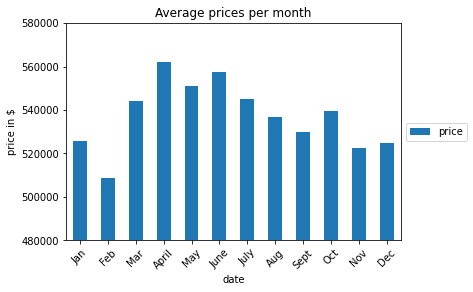

In [10]:
# add column price per sqft
df_king_county.eval('sqft_price = price / sqft_living', inplace=True)  
df_king_county.sqft_price = df_king_county.sqft_price.apply(lambda x: round(x, 2)) 


#what month had the lowest average price?
#change date to months only
df_months = df_king_county.copy()
df_months.date = df_king_county.date.dt.month
#df_months.groupby('date').mean().price.plot(kind='bar')

df_month_mean = df_months.groupby('date').mean().price
labels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

df = pd.DataFrame({'date': labels,'price': df_month_mean.values})
ax = plt.subplot()
fig = df.plot(kind = 'bar', x = 'date', y = 'price', ax = ax)
plt.xticks(rotation =45)
plt.ylabel('price in $')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(480000, 580000)
plt.title('Average prices per month')

## Comparison of average prices in May 2014 and May 2015

Text(0.5, 1.0, 'Average sqft prices in May 2014 and May 2015')

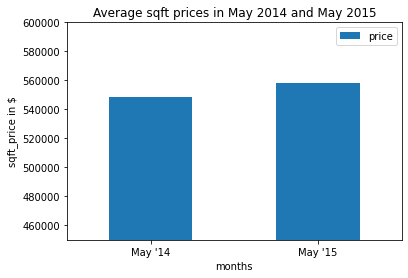

In [11]:
mask_may14 = (df_king_county['date'] < '2014-06-01')
a = df_king_county.price.loc[mask_may14].mean()

mask_may15 = (df_king_county['date'] < '2015-06-01') & (df_king_county['date'] >= '2015-05-01')
b = df_king_county.price.loc[mask_may15].mean()

dict_may = {'months': ["May '14", "May '15"], 'price': [a,b]}

df_may = pd.DataFrame.from_dict(dict_may)
df_may.head()

fig_may = df_may.plot(kind='bar', x = 'months', y = 'price')
plt.xticks(rotation = 0)
plt.ylabel('sqft_price in $')
plt.ylim(450000, 600000)
plt.title('Average sqft prices in May 2014 and May 2015')


## Comparison of average sqft prices over months

Text(0.5, 1.0, 'Average sqft prices per month')

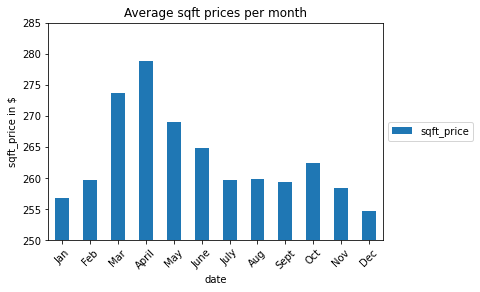

In [12]:
df_month_mean = df_months.groupby('date').mean().sqft_price
df2 = pd.DataFrame({'date': labels,'sqft_price': df_month_mean.values})
ax2 = plt.subplot()
fig2 = df2.plot(kind = 'bar', x = 'date', y = 'sqft_price', ax = ax2)
plt.xticks(rotation =45)
plt.ylabel('sqft_price in $')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(250, 285)
plt.title('Average sqft prices per month')


## How many houses are sold every month?

<AxesSubplot:title={'center':'Houses sold'}, xlabel='date', ylabel='number of houses sold'>

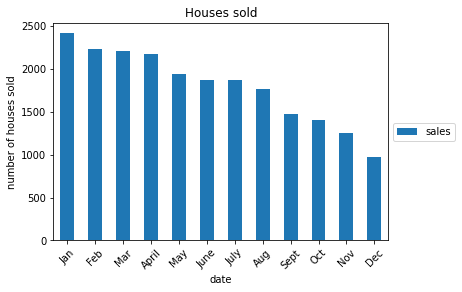

In [13]:
df = pd.DataFrame({'date': labels,'sales': df_months.date.value_counts()})
ax = plt.subplot()
fig = df.plot(kind = 'bar', x = 'date', y = 'sales', ax = ax)
plt.xticks(rotation =45)
plt.ylabel('number of houses sold')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Houses sold')
ax


Text(0.5, 0, 'Number of houses sold')

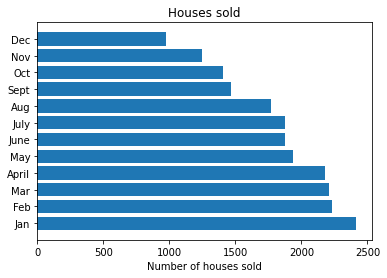

In [14]:
plt.barh(y=df.date, width=df.sales)
plt.title('Houses sold')
plt.xlabel('Number of houses sold')

# Hypothesis 2: High grade houses are sold at higher price 

In [15]:
d=df_king_county[['grade', 'price']]
d.sort_values('grade')  
df_king_county.grade.min()
df_king_county.grade.max()


13

Grade has values from 3 to 13.


<AxesSubplot:xlabel='grade', ylabel='price'>

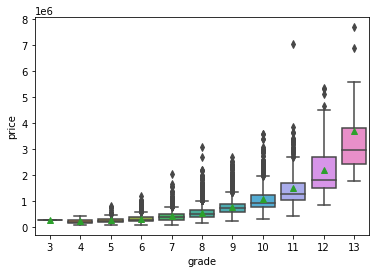

In [16]:
# grade vs price
sns.boxplot(x='grade', y = 'price', data=df_king_county, showmeans = True)

In [17]:
#create OLS model
X = df_king_county.grade
X = sm.add_constant(X)
y = df_king_county.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 1.740e+04
Date:                Mon, 18 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:47:52   Log-Likelihood:            -3.0101e+05
No. Observations:               21597   AIC:                         6.020e+05
Df Residuals:                   21595   BIC:                         6.020e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.061e+06   1.23e+04    -86.396      0.000   -1.09e+06   -1.04e+06
grade       2.092e+05   1585.790    131.895      0.000    2.06e+05    2.12e+05
==============================================================================
Omnibus:                    19879.964   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2043898.709
Skew:                           4.081   Prob(JB):                         0.00
Kurtosis:                      49.954   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plotting the result of the linear regression, i.e. regression loine.

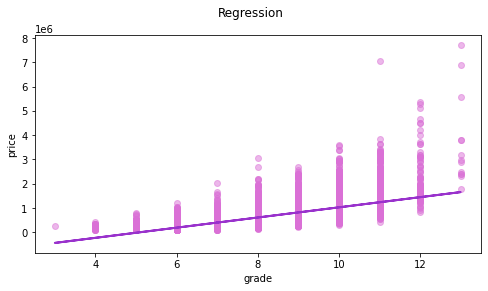

In [18]:

intercept, slope = results.params

fig, ax = plt.subplots(figsize=(8, 4))
x = df_king_county.grade
# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Regression')
# plotting regression line
ax.plot(x, x*slope +intercept, '-', color='darkorchid', linewidth=2);
ax.set_ylabel("price");
ax.set_xlabel("grade");

## There is definitely a relationship between grade and price. But one feature is not enough to make a good prediction on the price. 
## The heatmap  and the pairchart below show that there a six features that have a high correlation with the price: 
* bedrooms
* sqft_living
* grade
* sqft_above
* sqft_living15
* sqft_price

/var/folders/ml/wvx29l8j6h1gp24y92jgbnvw0000gn/T/ipykernel_40333/3259104049.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_heatmap = df_king_county.drop('id',1)
/var/folders/ml/wvx29l8j6h1gp24y92jgbnvw0000gn/T/ipykernel_40333/3259104049.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_heatmap.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

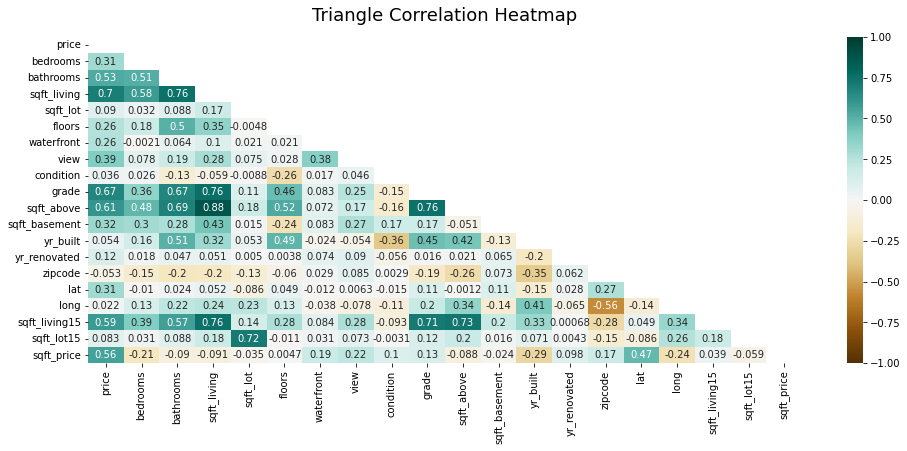

In [19]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
df_heatmap = df_king_county.drop('id',1) 
mask = np.triu(np.ones_like(df_heatmap.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_heatmap.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

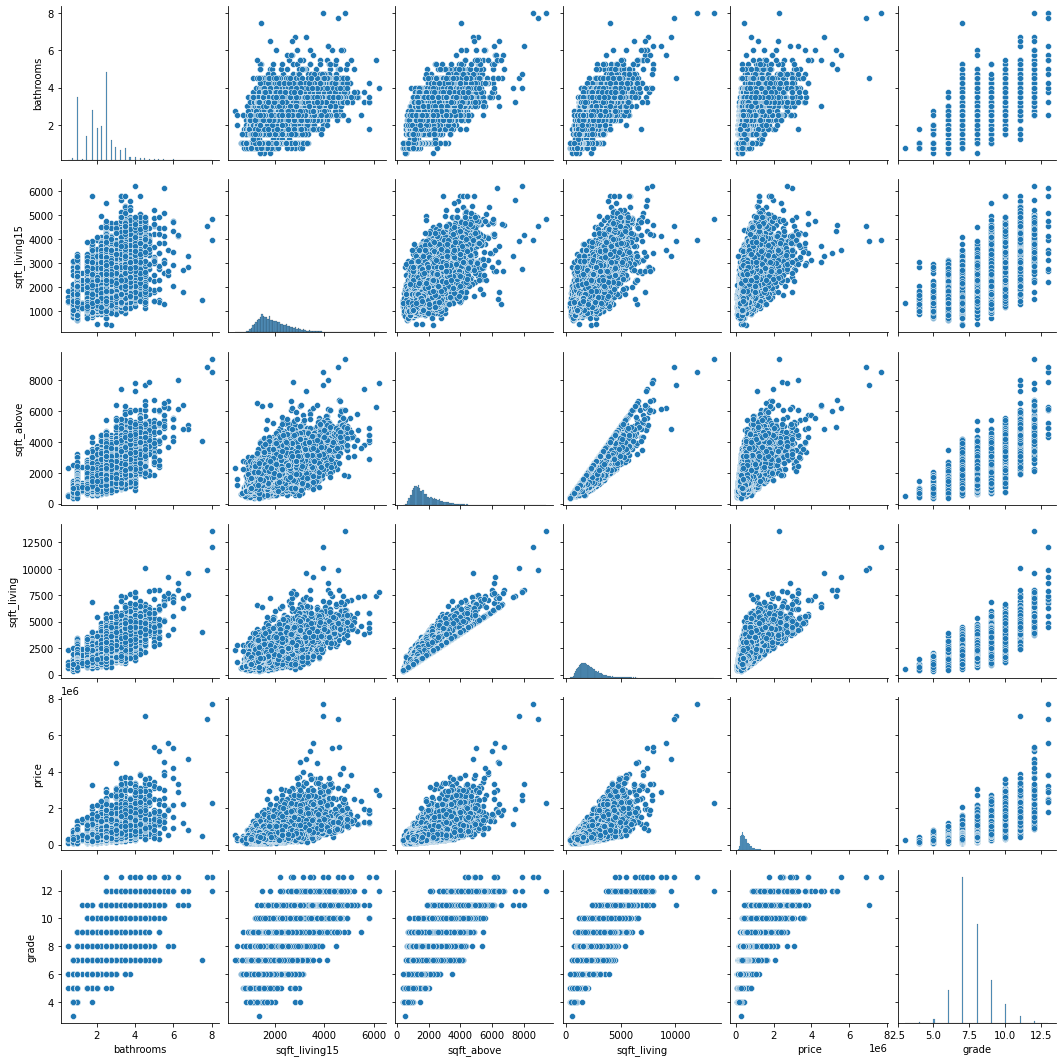

In [20]:
x_columns = ['bathrooms','sqft_living15', 'sqft_above', 'sqft_living', 'price', 'grade']#sqft_price
sns.pairplot(df_king_county[x_columns])

## Creating OLS model with  6 features. The result is better than the regression with only one feature, grade. 
## The R-squared is 0.882 vs 0.446.

In [37]:
#create OLS model
X = df_king_county[['bathrooms', 'sqft_living15', 'sqft_above', 'grade', 'sqft_living']]#sqft_price
X = sm.add_constant(X)
y = df_king_county.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     5161.
Date:                Mon, 18 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:49:30   Log-Likelihood:            -2.9890e+05
No. Observations:               21597   AIC:                         5.978e+05
Df Residuals:                   21591   BIC:                         5.979e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.52e+05   1.36e+04    -48.079      0.000   -6.79e+05   -6.25e+05
bathrooms     -3.567e+04   3440.363    -10.369      0.000   -4.24e+04   -2.89e+04
sqft_living15    22.2598      4.032      5.520      0.000      14.356      30.164
sqft_above      -80.6961      4.458    -18.101      0.000     -89.434     -71.958
grade          1.119e+05   2470.776     45.293      0.000    1.07e+05    1.17e+05
sqft_living     245.5631      4.528     54.238      0.000     236.689     254.437
==============================================================================
Omnibus:                    17251.912   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1128620.760
Skew:                           3.361   Prob(JB):                         0.00
Kurtosis:                      37.771   Cond. No.                     2.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
x_columns = ['bathrooms', 'sqft_price', 'sqft_living15', 'sqft_above', 'grade', 'sqft_living']


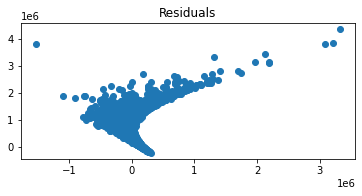

In [23]:
pred_val = results.fittedvalues.copy()
true_val = df_king_county['price'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
ax.set_title("Residuals")
_ = ax.scatter(residual, pred_val)

# Hypothesis 3: Prices rely on the area, i.e. Zipcode

## Converting zipcodes to citynames. There are 70 zipcodes in the dataframe.

In [24]:
df_king_county.groupby('zipcode').count()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,sqft_price
zipcode,,,,,,,,,,,,,,,,,,,,,
98001,361,361,361,361,361,361,361,361,361,361,...,361,361,361,361,361,361,361,361,361,361
98002,199,199,199,199,199,199,199,199,199,199,...,199,199,199,199,199,199,199,199,199,199
98003,280,280,280,280,280,280,280,280,280,280,...,280,280,280,280,280,280,280,280,280,280
98004,317,317,317,317,317,317,317,317,317,317,...,317,317,317,317,317,317,317,317,317,317
98005,168,168,168,168,168,168,168,168,168,168,...,168,168,168,168,168,168,168,168,168,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98177,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
98178,262,262,262,262,262,262,262,262,262,262,...,262,262,262,262,262,262,262,262,262,262
98188,136,136,136,136,136,136,136,136,136,136,...,136,136,136,136,136,136,136,136,136,136


In [25]:
def get_location(code):
    zcdb = ZipCodeDatabase()
    zipcode = zcdb[code]
    return zipcode.city


In [26]:
df_king_county.price.min()
df_king_county.query('price == 78000')
get_location(98168)

df_king_county.price.max()
df_king_county.query('price == 7700000')
get_location(98102)


'Seattle'

# The most expensive house was sold in Seattle for 7 700 000 $
# The cheapest house was also sold in Seattle for 78 K $

Text(0.5, 0, ' ')

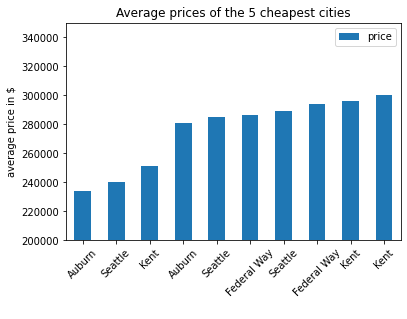

In [27]:
b = df_king_county.groupby('zipcode').price.mean().sort_values().head(10)
  
dfb = pd.DataFrame({'zipcode': [get_location(z) for z in b.index], 'price': b.values})
axb = plt.subplot()
figb = dfb.plot(kind = 'bar', x = 'zipcode', y = 'price', ax = axb)
plt.xticks(rotation=45)
plt.ylabel('average price in $')
plt.title('Average prices of the 5 cheapest cities')
plt.ylim(200000,350000)
plt.xlabel(' ')


zipcode
98005    8.102897e+05
98119    8.497148e+05
98006    8.599386e+05
98105    8.632289e+05
98109    8.800778e+05
98102    8.996077e+05
98112    1.096239e+06
98040    1.194874e+06
98004    1.356524e+06
98039    2.161300e+06
Name: price, dtype: float64

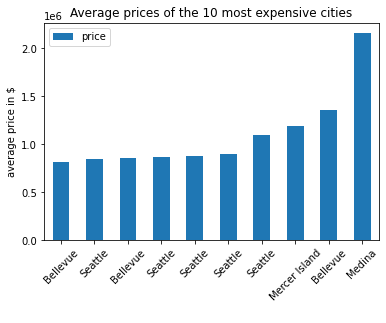

In [28]:
b = df_king_county.groupby('zipcode').price.mean().sort_values().tail(10)
dfb = pd.DataFrame({'zipcode': [get_location(z) for z in b.index],  'price': b.values})
axb = plt.subplot()
figb = dfb.plot(kind = 'bar', x = 'zipcode', y = 'price', ax = axb)
plt.xticks(rotation=45)
plt.ylabel('average price in $')
plt.title('Average prices of the 10 most expensive cities')
get_location(98001)
plt.xlabel(' ')

b

# Distribution of price

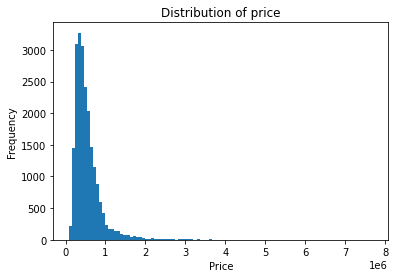

In [29]:
plt.hist(df_king_county.price, bins=100)
plt.gca().set(title='Distribution of price', xlabel= 'Price', ylabel='Frequency');


# Recommendations for the stakeholder

In [30]:
a= df_king_county.query('waterfront ==1').price.mean()
a

1717214.7260273972

In [31]:
b=df_king_county.query('waterfront==0').price.mean()
b

532286.2219943126

Text(0.5, 0, '')

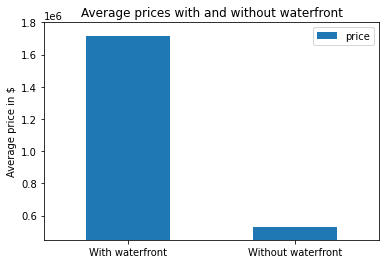

In [32]:
dict_may = {'months': ["With waterfront", "Without waterfront"], 'price': [a,b]}

df_may = pd.DataFrame.from_dict(dict_may)
df_may.head()

fig_may = df_may.plot(kind='bar', x = 'months', y = 'price')
plt.xticks(rotation = 0)
plt.ylabel('Average price in $')
plt.ylim(450000, 1800000)
plt.title('Average prices with and without waterfront')
plt.xlabel('')

